<a href="https://colab.research.google.com/github/elhamsh93/segmentation/blob/main/MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Apr 20 20:03:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

--2023-04-20 20:04:03--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  11.4MB/s    in 5.4s    

2023-04-20 20:04:09 (9.56 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



In [4]:
!unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [5]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../ 
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 322721, done.
remote: Counting objects: 100% (706/706), done.
remote: Compressing objects: 100% (631/631), done.
remote: Total 322721 (delta 594), reused 128 (delta 70), pack-reused 322015
Receiving objects: 100% (322721/322721), 653.77 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (296624/296624), done.


In [6]:
import os 
import numpy as np
import torch
import torchvision
import torch.utils.data
from PIL import Image 

In [9]:
image = Image.open('/content/PennFudanPed/PNGImages/FudanPed00001.png')
type(image)


PIL.PngImagePlugin.PngImageFile

In [10]:
type(image.convert('RGB'))

PIL.Image.Image

In [11]:
mask = Image.open('/content/PennFudanPed/PedMasks/FudanPed00001_mask.png')
mask = np.array(mask)
     
obj_ids = np.unique(mask)
obj_ids

array([0, 1, 2], dtype=uint8)

In [48]:
class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms = None) -> None:
    super().__init__()
    self.root = root
    self.transforms = transforms
    self.images = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
    self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

  def __getitem__(self, idx):
    #load image and it's mask
    image_path = os.path.join(self.root, 'PNGImages', self.images[idx]) 
    mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx]) 

    image = Image.open(image_path).convert('RGB')
    # We did not convert mask to RGB because
    # each color coresponds to a different instance with 0 being background
    mask = Image.open(mask_path)
    mask = np.array(mask)
     
    # get bbox coordinates for each mask
    obj_ids = np.unique(mask)
    # first id is 0 which is the background so remove it
    obj_ids = obj_ids[1:]

    masks = mask == obj_ids[:, None, None]

    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      # we get masks pixels for i-th object and calculate its two points  
      # returns the indices of elements in an input array where the given condition is satisfied
      pos = np.where(masks[i])

      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    # calculating area 
    xmin_pos = 0
    ymin_pos = 1
    xmax_pos = 2
    ymax_pos = 3

    area = (boxes[:, ymax_pos] - boxes[:, ymin_pos]) * (boxes[:, xmax_pos] - boxes[:, xmin_pos])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['masks'] = masks
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms is not None:
      image, target = self.transforms(image, target)
    
    return image, target
  
  def __len__(self):
    return len(self.images)


In [49]:
dataset = PennFudanDataset('/content/PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FF71ACC1820>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [50]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def transform_img(is_train):
  transforms=[]
  transforms.append(T.PILToTensor())
  transforms.append(T.ConvertImageDtype(torch.float))
  if is_train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [15]:
def new_concat(batch):
  return tuple(zip(*batch))

In [103]:
net = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('/content/PennFudanPed/', transform_img(is_train=True))
dataloader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=new_concat,
)
#For Training
images, targets = next(iter(dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
print(type(images[0]))
output = net(images, targets)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torch.Tensor'>


In [104]:
net.eval()
predictions = net(images)
predictions

[{'boxes': tensor([[200.4055, 104.2952, 344.4671, 389.4734],
          [  0.4074, 102.6342,  87.6053, 387.5431],
          [ 32.8421,  93.4394,  86.5295, 263.9793],
          [315.4944, 143.6348, 358.7353, 271.5578],
          [276.4492,  86.7645, 342.7707, 224.4155],
          [275.9004,  86.3937, 350.8131, 376.2280],
          [ 35.5069,  90.8301, 101.7102, 377.0482],
          [ 38.0454, 255.4929,  91.4360, 306.8091],
          [ 37.2235, 258.4952,  92.2660, 306.6631],
          [281.8548, 132.2042, 359.9936, 265.7457],
          [319.9862, 214.8792, 355.4789, 272.3009],
          [231.3349,  97.2723, 343.6678, 254.4222],
          [  6.4994, 204.9288,  32.9983, 254.0600],
          [  0.0000, 106.6649,  57.4373, 297.4861],
          [ 45.0915,   0.0000, 229.2069, 216.2086],
          [277.9545, 126.1768, 358.0773, 256.5946],
          [280.2082, 257.3757, 353.4760, 357.0563],
          [261.2394, 314.4971, 293.8555, 363.7855],
          [319.4839, 172.5860, 356.8007, 273.6763],
   

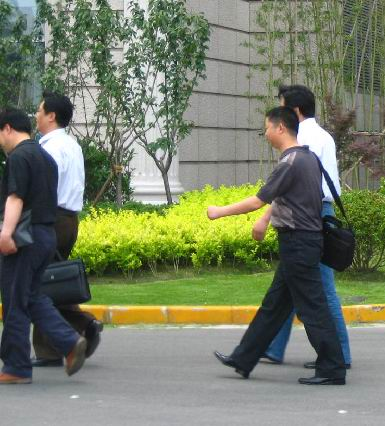

In [105]:
Image.fromarray(images[0].mul(255).permute(1,2,0).byte().numpy())

In [106]:
predictions[0]['masks'].shape

torch.Size([21, 1, 426, 385])

In [107]:
coco_names =[
    '__background__','person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(coco_names)

81

In [108]:
def getoutputs(image, model, threshold):
  with torch.no_grad():
    outputs = model([image])
  #get all the scores
  scores = list(outputs[0]['scores'].detach().cpu().numpy())
  # index of those scores which are above a certain threshold
  thresholded_preds_indices = [scores.index(i) for i in scores if i > threshold]
  thresholded_preds_count = len(thresholded_preds_indices)
  # get the masks
  masks = (outputs[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  # discard masks for objects which are below threshold
  masks = masks[:thresholded_preds_count]
  # get the bounding boxes in (x1, y1), (x2, y2) format
  boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in outputs[0]['boxes'].detach().cpu()]
  # discard bboxes below threshold value
  boxes = boxes[:thresholded_preds_count]
  # get the classes labesl
  labels = [coco_names[i] for i in outputs[0]['labels'] ]
  return masks, boxes, labels

In [109]:
net.eval()
masks, boxes, labels = getoutputs(images[0], net, threshold=0.96) 

In [110]:
masks.shape

(3, 426, 385)

In [111]:
import random 
import cv2
from google.colab.patches import cv2_imshow

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 # how much transparency to apply
    beta = 0.6 # alpha + beta should equal 1
    gamma = 0 # scalar added to each sum
 
    for i in range(0, len(masks)):
      red_map = np.zeros_like(masks[i]).astype(np.uint8)
      green_map = np.zeros_like(masks[i]).astype(np.uint8)
      blue_map = np.zeros_like(masks[i]).astype(np.uint8)
      # apply random color mask to each object
      color = COLORS[random.randrange(0, len(COLORS))]
      red_map[masks[i] == 1], green_map[masks[i] == 1],blue_map[masks[i] == 1] =color
      # combine all the masks into single image
      segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
      # convert from RGB to OpenCV BGR format
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      # apply mask on the image
      cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
      # draw the bboxes around the objects 
      cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, thickness=2)
      #put the label text above the objects
      cv2.putText(image, labels[i], (boxes[i][0][0], boxes[i][0][1] -10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color,
                  thickness=2, lineType=cv2.LINE_AA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image
    
        
    

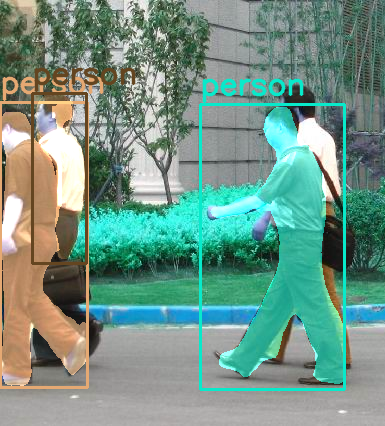

In [112]:
result = draw_segmentation_map(images[0].mul(255).permute(1, 2, 0).byte().numpy(), masks, boxes, labels)
cv2_imshow(result)

In [113]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                   hidden_layer,
                                                   num_classes)

In [114]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [115]:
train_dataset = PennFudanDataset('/content/PennFudanPed/', transform_img(is_train=True))
test_dataset = PennFudanDataset('/content/PennFudanPed/', transform_img(is_train=False))

torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-50])
test_dataset = torch.utils.data.Subset(test_dataset, indices[-50:])

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=new_concat,
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=new_concat,
)


In [116]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [117]:
num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, train_dataloader, device= device )


Epoch: [0]  [ 0/60]  eta: 0:01:02  lr: 0.000090  loss: 5.5566 (5.5566)  loss_classifier: 0.7420 (0.7420)  loss_box_reg: 0.5945 (0.5945)  loss_mask: 4.1936 (4.1936)  loss_objectness: 0.0133 (0.0133)  loss_rpn_box_reg: 0.0133 (0.0133)  time: 1.0387  data: 0.3563  max mem: 4038
Epoch: [0]  [10/60]  eta: 0:00:29  lr: 0.000936  loss: 1.6787 (2.7477)  loss_classifier: 0.5625 (0.4967)  loss_box_reg: 0.3457 (0.3701)  loss_mask: 1.0558 (1.8435)  loss_objectness: 0.0319 (0.0314)  loss_rpn_box_reg: 0.0049 (0.0060)  time: 0.5963  data: 0.0430  max mem: 4038
Epoch: [0]  [20/60]  eta: 0:00:22  lr: 0.001783  loss: 0.7985 (1.7264)  loss_classifier: 0.2010 (0.3199)  loss_box_reg: 0.2350 (0.2741)  loss_mask: 0.3616 (1.1004)  loss_objectness: 0.0258 (0.0262)  loss_rpn_box_reg: 0.0041 (0.0058)  time: 0.5482  data: 0.0108  max mem: 4038
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 0.5764 (1.3580)  loss_classifier: 0.1119 (0.2496)  loss_box_reg: 0.1855 (0.2589)  loss_mask: 0.2417 (0.8219)  loss_ob

In [118]:
images, targets = next(iter(train_dataloader))
images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# print(type(images[0]))
# output = net(images, targets)

In [119]:
model.eval()
masks, boxes, labels = getoutputs(images[0].cuda(), model, threshold=0.8)

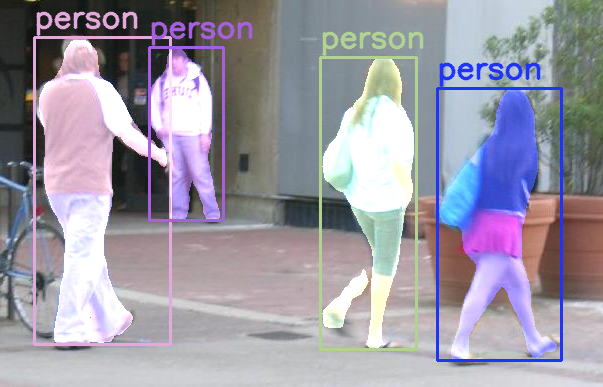

In [120]:
result = draw_segmentation_map(images[0].mul(255).permute(1, 2, 0).byte().numpy(),masks, boxes, labels)
cv2_imshow(result)